# Big Data Project
Il presente progetto è stato realizzato da Luigi Gatto, Davide Lavalle e Cedric Ferdico. 
Il progetto di esame (a.a. 2020-2021) è una competizione Kaggle: si tratta di un data set di frodi su carte di credito in cui sono presenti solo 492 frodi su 284808 transazioni. I dati contengono i campi "Time", "V1" ... "V28", "Amount" e "Class" che descriveremo in seguito.

E' stato richiesto di effettuare tutti i passi di data cleaning/inputation e una analisi delle feature rilevanti ai fini della classificazione. 
La metrica richiesta è la Area Under the Precision-Recall Curve (AUPRC). Inoltre, è stata necessario trovare una modalità di visualizzazione dei dati classificati in 2D o 3D che consenta di mettere in relazione i punti appartenenti a ciascuna classe con le feature utilizzate per la classificazione ai fini di apprezzare l'effettiva separazione tra le classi. (Suggerimento: utilizzare il Multi-Dimensional Scaling (MDS).)

## 0.Ecosistema
Per la realizzazione del progetto, è stato deciso di utilizzare i seguenti strumenti:
- HDFS: per o storage del dataset (simulando un cluster unitario di datanode); 
- Spark: per il recupero (da HDFS) e l'elaborazione del dataset;
- Pandas: per la manipolazione e l'analisi dei dati;
- Scikitlearn: per l'apprendimento automatico e le metriche di valutazione dei modelli;
- Imblearn: conferisce dei tool utili alla classificazione di classi sbilanciate (utilizzata per effettuare il sovracampionamento);
- Numpy: per la gestione di matrici e array multidimensionali di grandi dimensioni e l'utilizzo di funzioni matematiche di alto livello per operare su queste strutture dati;
- Matplotlib/Seaborn: per la visualizzazione dei dati.


# 1.Descrizione del dataset

Il dataset analizzato nel progetto è un insieme di record di transazioni di carte di credito a cui è stato effettuato la PCA (per motivi di privacy). I dati sono raccolti in maniera continua: il tempo è segnato all'interno della colonna "Time" con un intero che indica l'ammontare di secondi passati tra la transazione i-esima e la prima (che, di conseguenza ha il valore di "Time" a 0). 
Il dataset analizzato presenta 284808 di record di transazioni al momento dell'analisi in questo progetto.

Il dataset è fornito in formato .csv.


## 1.1.DATASET
In questa tabella andremo a riassumere il contenuto del dataset dal punto di vista delle features, descrivendone il tipo ed il contenuto.

| **Feature** | **Tipo** | **Descrizione** |
|------------ |------------ |------------ |
| "Time" | _Int_ | Valore numerico che indica l'ammontare di secondi trascorsi tra la prima transazione e la i-esima, il valore per la prima transazione è 0. |
| "V1"..."V28" | _Float_ | Feature di dettaglio della transazione convertite con la PCA per questioni di privacy. |
| "Amount" | _Float_ | Valore numerico che indica l'ammontare della transazione. |
| "Class" | _Boolean_ | Valore 0/1 che indica se la transazione in oggetto sia frode (1) o lecita (0). |

# 2.Inizializzazione dell'ambiente
Qui andremo a descrivere brevemente la fase di inizializzazione degli strumenti utilizzati per il progetto.

## 2.1.Importazione del dataset in HDFS

Per prima, dopo aver effetuato l'installazione ed il setup di HDFS, è necessario avviare tutti i servizi Hadoop.
Per farlo è sufficiente eseguire un comando da CLI: 

``` >> start-all ```

A questo punto, una volta avviati tutti i servizi, sarà possibile caricare in HDFS il dataset.
Per effettuare l'upload, sarà sufficiente eseguire un altro comando CLI:

```>> hdfs fs -put "local/path/to/file.csv" "remote/path/" ```

Dove il primo parametro sta ad indicare la directory locale in cui è conservato il file .csv mentre il secondo indicherà la directory del file system distribuito in cui il dataset sarà caricato.

## 2.2.Spark
L'inizializzazione dell'ambiente Spark consiste nell'importazione dei relativi moduli e nell'inizializzazione di una nuova SparkSession.
Il motivo per cui è stato preso in considerazione l'utilizzo di Apache Spark è stato il suo ottimo rendimento in ambiti applicativi come questo. Infatti, questo strumento, è caratterizzato da un'alta velocità di elaborazione e di analisi avanzata; inoltre, dispone di un supporto di integrazione multipla con le operazioni a basso costo di Hadoop per la gestione dell’hardware e l’immagazzinamento dei dati.

In [1]:
import findspark   #SEMBRA ESSERE TOTALMENTE INUTILE

location = findspark.find()
findspark.init(location)

from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession.builder \
    .appName("Progetto BigData Gatto - Lavalle - Ferdico A.A. 2020/2021") \
    .getOrCreate()


# 3.Lettura del dataset da HDFS con Spark

Il codice seguente permette la lettura del file da HDFS e quindi l'importazione del dataset in formato .csv all'interno del dataframe secondo lo schema appena creato.
Il dataset è conservato in una simulazione di filesystem distribuito in locale. 
(Questa scelta è stata effettuata per permetterci di cimentarci nell'implementazione di un fs distribuito con lo strumento Hadoop)

In [2]:
dataSet = spark.read \
    .csv('hdfs://localhost:9090/user/cedric/bigdata/creditcard.csv', header = 'True', inferSchema='True')

# 4.Dataset preprocessing
La fase di preprocessing è necessaria per preparare il dataset appena caricato prima dell'analisi vera e propria. I dati presenti possono infatti presentare errori, dati mancanti o valori non previsti. L'obiettivo del preprocessing è quindi quello di pulire tali informazioni rimuovendo o "curando" i dati che presentano rumore o qualsiasi altro tipo di inconsistenze.

## 4.1 Osservazione sul dataset


Convertiamo in Pandas per una gestione più semplice per poter fare i grafici

In [5]:
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt

df = dataSet.toPandas()

ImportError: Can't determine version for numexpr

Grafico X: Amount --> Y: Class

È possibile dedurre che il dataset è sbilanciato e che le transazioni con class = 1 (frodi) hanno un valore di Amount relativamente basso (< 5000).
Grafico: X: Time -- Y:Amount (Rosso frode - Blu non frode)

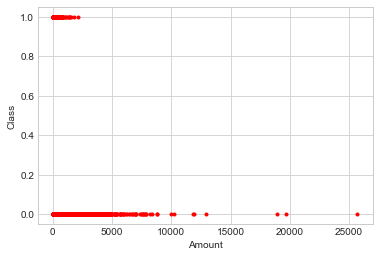

In [ ]:
X = df['Amount']
Y = df['Class']

plt.style.use('seaborn-whitegrid')
plt.xlabel("Amount")
plt.ylabel("Class")
plt.scatter(X, Y, marker = ".", color = 'red')
plt.show()

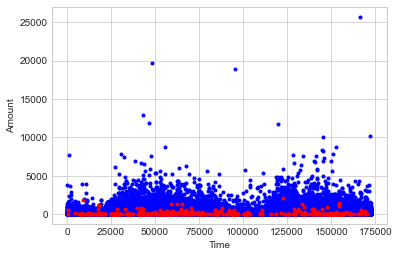

In [ ]:
#Grafico non frode
xlim = df['Time'].max() * 1.2
ylim = df['Amount'].max() * 1.2

X = np.where(df['Class']==0, df['Time'], None)
Y = np.where(df['Class']==0, df['Amount'], None)

plt.style.use('seaborn-whitegrid')
plt.xlabel("Time")
plt.ylabel("Amount")
plt.scatter(X, Y, marker = ".", color = "blue")

X = np.where(df['Class']==1, df['Time'], None)
Y = np.where(df['Class']==1, df['Amount'], None)
plt.scatter(X, Y, marker = ".", color = "red")

Dall'esecuzione precedente è possibile notare come tutte le features presenti nel dataset non presentino dati mancanti.
Una piccola parentesi va invece aperta per l'analisi predittiva. Ricordando che è richiesta la previsione della classe di appartenza di una transazione, le caratteristiche che possono in qualche modo influenzare questo campo andranno sicuramente mantenute. Le operazioni successive andranno ad identificare le feature meno rilevanti e che andremo ad eliminare.

## 4.X Data cleaning
Banalmente, la prima operazione può essere quella di individuare le informazioni che presentano caratteristiche con valori mancanti. Il trattamento di valori mancanti può avvenire fondamentalmente in due modi: cancellazione o imputazione. La scelta corretta dipende dall'obiettivo dell'analisi e dalla possibile conoscenza a priori del problema, oltre ovviamente che dalle quantità di tali valori nulli.

In [ ]:
nullValues = dataSet.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dataSet.columns])
nullValues.show()

+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|Time| V1| V2| V3| V4| V5| V6| V7| V8| V9|V10|V11|V12|V13|V14|V15|V16|V17|V18|V19|V20|V21|V22|V23|V24|V25|V26|V27|V28|Amount|Class|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|     0|    0|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+



## 4.X Eliminazione delle features meno rilevanti



### 4.X.1 Matrice di correlazione

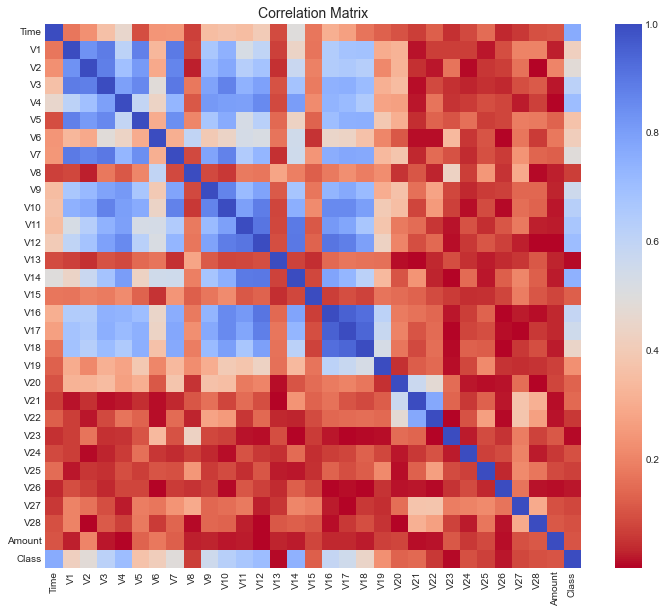

Time      False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13        True
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23        True
V24       False
V25       False
V26        True
V27       False
V28       False
Amount    False
Class     False
Name: Class, dtype: bool


In [ ]:
import seaborn as sns

# shuffle before creating subsamples

df_fraud = df.loc[df.Class == 1]
df_non_fraud = df.loc[df.Class == 0][1000:1492]

dfFifty = pd.concat([df_fraud, df_non_fraud])

plt.figure(figsize=(12, 10))
corr = dfFifty.corr()
corr = pd.DataFrame.abs(corr)
fig = sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})
fig.set_title('Correlation Matrix', fontsize=14)
plt.show()

soglia = 0.05
print(corr["Class"] < soglia)

Dalla matrice di correlazione eliminiamo questo, questo e questo

In [ ]:
dfFinal = df.drop(["V13", "V23"], axis = 1) # <-- dalla matrice di correlazione

## Fisher Score

In [ ]:
from skfeature.function.similarity_based import fisher_score

df_fraud = df.loc[df.Class == 1]
df_non_fraud = df.loc[df.Class == 0][0:492]

dfFifty = pd.concat([df_fraud, df_non_fraud])

fisherX = np.array(dfFifty.iloc[:, dfFifty.columns != 'Class'])
fisherY = np.array(dfFifty.iloc[:, dfFifty.columns == 'Class'])
fisherY = fisherY.reshape(1, -1)[0]

idx = fisher_score.fisher_score(fisherX, fisherY) #returns rank directly instead of fisher score. so no need for feature_ranking
idx = fisher_score.feature_ranking(idx)
print(idx)

[ 0 14 12  4 11 10  3 16  9 17  7  2  6 18  1  5 19 15 20 21 29 28 24 27
 25  8 26 22 13 23]


Dal fisher score eliminiamo questo, questo e questo

In [ ]:
dfFinal = dfFinal.drop(["Time", "V3", "V6", "V11", "V14"], axis = 1) # <-- dal fisher score

In [ ]:
#prendo le prime 3 colonne
dfFinalClassFalse = dfFinal.loc[dfFinal.Class == 0]
dfFinalClassFalse = dfFinalClassFalse.drop(["Class"], axis = 1)

dfFinalClassTrue = dfFinal.loc[dfFinal.Class == 1]
dfFinalClassTrue = dfFinalClassTrue.drop(["Class"], axis = 1)

from sklearn.manifold import MDS

embedding = MDS(n_components=3)
xTrue_transformed = embedding.fit_transform(dfFinalClassTrue)
xFalse_transformed = embedding.fit_transform(dfFinalClassFalse.head(1000))


In [ ]:
plt.style.use('seaborn-whitegrid')
plt.scatter(xTrue_transformed[:, 0], xTrue_transformed[:, 1], marker = ".", color = 'red')
plt.scatter(xFalse_transformed[:, 0], xFalse_transformed[:, 1], marker = ".", color = 'blue')
plt.show()


ax = plt.axes(projection='3d')
ax.scatter3D(xTrue_transformed[:, 0], xTrue_transformed[:, 1], xTrue_transformed[:, 2], c=xTrue_transformed[:, 2], cmap='Greens');
ax.scatter3D(xFalse_transformed[:, 0], xFalse_transformed[:, 1], xFalse_transformed[:, 2], c=xFalse_transformed[:, 2], cmap='Reds');

In [ ]:
from sklearn.metrics import pairwise_distances

pwsClassTrue = pairwise_distances(X = dfFinalClassTrue, metric="manhattan")
pwsClassFalse = pairwise_distances(X = dfFinalClassFalse.head(1000), metric="manhattan")

embedding = MDS(n_components=2, dissimilarity="precomputed", random_state = 104, verbose = 1)
xTrue_transformed = embedding.fit_transform(pwsClassTrue)
xFalse_transformed = embedding.fit_transform(pwsClassFalse)

plt.style.use('seaborn-whitegrid')
plt.scatter(xTrue_transformed[:, 0], xTrue_transformed[:, 1], marker = ".", color = 'green')
plt.scatter(xFalse_transformed[:, 0], xFalse_transformed[:, 1], marker = ".", color = 'red')
plt.show()

embedding = MDS(n_components=2, random_state = 104, verbose = 1)
xTrue_transformed = embedding.fit_transform(dfFinalClassTrue)
xFalse_transformed = embedding.fit_transform(dfFinalClassFalse.head(1000))

plt.style.use('seaborn-whitegrid')
plt.scatter(xTrue_transformed[:, 0], xTrue_transformed[:, 1], marker = ".", color = 'green')
plt.scatter(xFalse_transformed[:, 0], xFalse_transformed[:, 1], marker = ".", color = 'red')
plt.show()

In [ ]:
from sklearn.metrics import pairwise_distances

pwsClassTrue = pairwise_distances(X = dfFinalClassTrue, metric="manhattan")
pwsClassFalse = pairwise_distances(X = dfFinalClassFalse.head(1000), metric="manhattan")

embedding = MDS(n_components=3, dissimilarity="precomputed", random_state = 104)
xTrue_transformed = embedding.fit_transform(pwsClassTrue)
xFalse_transformed = embedding.fit_transform(pwsClassFalse)

ax = plt.axes(projection='3d')
ax.scatter3D(xTrue_transformed[:, 0], xTrue_transformed[:, 1], xTrue_transformed[:, 2], c=xTrue_transformed[:, 2], cmap='Greens')
ax.scatter3D(xFalse_transformed[:, 0], xFalse_transformed[:, 1], xFalse_transformed[:, 2], c=xFalse_transformed[:, 2], cmap='Reds')

In [ ]:
embedding = MDS(n_components=3, random_state = 104)
xTrue_transformed = embedding.fit_transform(dfFinalClassTrue)
xFalse_transformed = embedding.fit_transform(dfFinalClassFalse.head(1000))

ax = plt.axes(projection='3d')
ax.scatter3D(xTrue_transformed[:, 0], xTrue_transformed[:, 1], xTrue_transformed[:, 2], c=xTrue_transformed[:, 2], cmap='Greens')
ax.scatter3D(xFalse_transformed[:, 0], xFalse_transformed[:, 1], xFalse_transformed[:, 2], c=xFalse_transformed[:, 2], cmap='Reds')

## 3.2 Salvataggio del dataset.csv
E' sicuramente conveniente salvare direttamente nel Drive personale il dataset così ottenuto per non ripetere i passaggi di data cleaning appena descritti ad ogni nuovo accesso a Colab. Per memorizzare il cleaned dataset, è possibile semplicemente utilizzare il metodo .write() fornito da Spark.
@Todo Dobbiamo farlo?

## 4. Importazione del cleaned dataset
cleaned_accidents_dataset.csv
Andiamo quindi ad importare il nuovo dataset cleaned_accidents_dataset.csv . Per farlo è necessario costruire nuovamente lo schema del dataframe che ospiterà il dataset e infine utilizzare il metodo read di Spark.

Divisione del dataset in training set e validation set

### 6.4 Scelta delle features @ToDo noi non possiamo farla, che ci mettiamo?

Più paragrafi sono stati dedicati alla pulizia del dataset, alla scelta delle features e quindi alla rimozione delle caratteristiche con dati mancanti o palesemente non necessari all'analisi. Per l'analisi predittiva ciò non basta,infatti alcune delle features possono essere in qualche modo implicitamente correlate al campo Severity , e per tale motivo utili alla sua predizione. Un possibile modo per individuare le features correlate è quello di utilizzare l'approccio statistico.
Calcolare le correlazioni tra la caratteristica Severity ed il resto è possibile calcolando la relativa matrice di correlazione. E' chiaro quindi che vanno escluse tutte le caratteristiche aventi una correlazione col campo preso in esame al di sotto di una certa soglia.
Per poter carcolare la matrice di correlazione, è possibile utilizzare un metodo fornito da Pandas. E' quindi necessario importare il dataset indicizzato all'interno di un suo dataframe:

Dalla matrice di correlazione appena ottenuta, va presa in considerazione soltanto la prima colonna ovvero quella relativa alle correlazioni tra la caratteristica Severity e ognuna delle altre caratteristiche.
Tanto è maggiore in valore assoluto la correlazione tra due variabili aleatorie, tanto più la conoscenza del valore di una è utile a prevedere il valore dell'altra. Per tale motivo è necessario calcolare i valori assoluti delle correlazioni tra
Severity e le altre caratteristiche, ed infine ordinarli in ordine decrescente:

6.8 Bilanciamento del dataset
Prima di continuare è necessario anche analizzare il bilanciamento delle classi appartenenti alla caratteristica Severity :

Il risulta mostra un bilanciamento non proprio uniforme. In particolare è possibile notare come la classe 1 e 4 sono quelle meno frequenti rispetto alle altre presenti. E' possibile bilanciare la distribuzione di tali classi attraverso l'oversampling. L'oversampling consiste nella duplicazione dei record delle le classi meno frequenti. Di conseguenza, va utilizzato il metodo .sample fornito sempre da Spark. Il metodo appena citato permette di specificare una frazione di record da estrarre dal dataframe da cui estrarre i campioni, con o senza sostituzione. L'oversampling sarà effettuato esclusivamente del training set per non influenzare i risultati della predizione da parte del modello.
Visuliazziamo la distribuzione delle classi per la stessa caratteristica ma soltanto per il Training Set:

Proviamo quindi a distribuire in maniera più uniforme tali classi tramite oversampling. E' evidente che l'oversampling debba essere seguito sui record aventi classi 1 , 3 e 4 di Severity .
Bisogna innanzitutto separare i record appartenenti alle stesse classe di Severity:

Come descritto prima, è necessario l'oversampling sui record appartenenti alle classi 1 , 3 e 4 . Il fattore di oversampling è gestibile tramite il parametro fraction di sample .

Controlliamo quindi se la distribuzione delle classi all'interno del dataset si è uniformata:

Valutazione dell'errore del modello ottenuto al passo precedente

## Dobbiamo eliminare MLP?

In [ ]:

#from sklearn import preprocessing
#
#standardScaler = preprocessing.StandardScaler()
#scaledTime = standardScaler.fit_transform(X = dfFinal[['Time']])
#scaledAmount = standardScaler.fit_transform(X = dfFinal[['Amount']])

#dfFinal['ScaledTime'] = scaledTime
# dfFinal['ScaledAmount'] = scaledAmount

# dfFinal = dfFinal.drop(['Time', 'Amount'], axis = 1)

# X = dfFinal.iloc[:, dfFinal.columns != 'Class']
# y = dfFinal.iloc[:, dfFinal.columns == 'Class']

# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.3, random_state = 50)

# from sklearn.metrics import recall_score
# from sklearn.neural_network import MLPClassifier

# #hidden_layer_sizes=(200,)
# MLPC = MLPClassifier(hidden_layer_sizes=(200,6), max_iter=10000, verbose=True)
# MLPC.fit(X_train, y_train.values.ravel())
# y_pred = MLPC.predict(X_test)
# # Obtenemos valores de recall
# recall_acc = recall_score(y_test, y_pred)
# print(recall_acc)
# print(MLPC.score(X_test, y_test))

               V1         V2        V4        V5        V7        V8  \
0       -1.359807  -0.072781  1.378155 -0.338321  0.239599  0.098698   
1        1.191857   0.266151  0.448154  0.060018 -0.078803  0.085102   
2       -1.358354  -1.340163  0.379780 -0.503198  0.791461  0.247676   
3       -0.966272  -0.185226 -0.863291 -0.010309  0.237609  0.377436   
4       -1.158233   0.877737  0.403034 -0.407193  0.592941 -0.270533   
...           ...        ...       ...       ...       ...       ...   
284802 -11.881118  10.071785 -2.066656 -5.364473 -4.918215  7.305334   
284803  -0.732789  -0.055080 -0.738589  0.868229  0.024330  0.294869   
284804   1.919565  -0.301254 -0.557828  2.630515 -0.296827  0.708417   
284805  -0.240440   0.530483  0.689799 -0.377961 -0.686180  0.679145   
284806  -0.533413  -0.189733 -0.506271 -0.012546  1.577006 -0.414650   

              V9       V10       V12       V15  ...       V19       V20  \
0       0.363787  0.090794 -0.617801  1.468177  ...  0.40399

C:\BigData\envs\BigData\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


0.7687074829931972
0.9992860737567735


In [ ]:
#F1 score
from sklearn.metrics import f1_score
f1result = f1_score(y_test, y_pred)
print(f1result)

NameError: name 'y_test' is not defined

# ADDESTRAMENTO

6.9 Training
Per l'addestramento è necessario importare i modelli da addestrare dalle librerie di Spark per la classificazione. Come modelli verranno utilizzati Decision Tree ed il classificatore di tipo probabilistico Naive Bayes per poter confrontare infine i risultati ottenuti.
Per poter inizializzare i modelli è necessario prima inserire come parametri la caratteristica che il modello deve predire Severity , e la colonna delle features .


Creiamo test set e train set dal dataset e visualizziamo le loro dimensioni

In [ ]:
from sklearn.model_selection import train_test_split

features = dfFinal[dfFinal.columns[:len(dfFinal.columns)-1]].to_numpy()
targets = dfFinal.Class.to_numpy()

X_train,X_test,Y_train,Y_test = train_test_split(features, targets, test_size=0.3, shuffle=True)
#X ingressi
print("Train Feature size : ", len(X_train))
print("Train Label size   :", len(Y_train))
print("Test Feature size  :", len(X_test))
print("Test Label size    :", len(Y_test))

Train Feature size :  199364
Train Label size   : 199364
Test Feature size  : 85443
Test Label size    : 85443


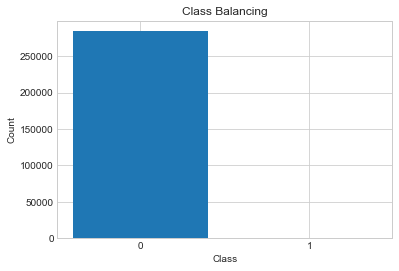

In [ ]:
target_un,count = np.unique(targets,return_counts=True)
plt.title("Class Balancing")
plt.xlabel("Class")
plt.ylabel("Count")
plt.bar([str(i) for i in target_un],count)
plt.show()

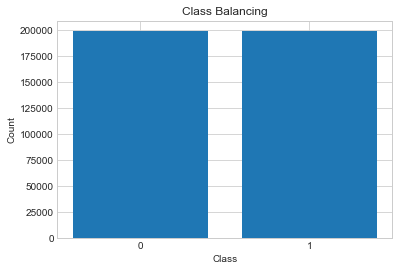

In [ ]:
from imblearn.over_sampling import SMOTE

#SOVRACAMPIONAMENTO SOLO DEL TRAINING SET IN MODO DA SBAGLIARE SOLO 1 VOLTA E NON N VOLTE NEL TEST SET
X_train, Y_train = SMOTE().fit_resample(X_train,Y_train)
Y_train = Y_train.reshape(-1,1)

target_balanced,count = np.unique(Y_train,return_counts=True)
plt.title("Class Balancing")
plt.xlabel("Class")
plt.ylabel("Count")
plt.bar([str(i) for i in target_balanced],count)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, criterion="entropy")
model.fit(X_train, Y_train)

C:\Users\utente\AppData\Local\Temp/ipykernel_10516/4214428992.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, Y_train)


RandomForestClassifier(criterion='entropy')

# 6 Prediction e valutazione dei modelli
Ora che i modelli sono stati addestrati, è finalmente possibile iniziare la predizione di Severity utilizzando il test set. Di conseguenza, viene utilizzato il metodo .transform() che restituisce direttamente il dataframe contenente la predizione dei modelli utilizzati e la relativa label corretta.
Per la valutazione dei modelli appena addestrati, vengono utilizzate le metriche fornite dalle librerie Scikit-learn , ovvero librerie di machine learning open-source scritte in Python.
Tutte le metriche fornite dalle librerie da Scikit-learn utilizzano come parametri di input y_true e y_pred . Queste rappresentano rispettivamente le label verità e le label predette dal classificatore. Tali parametri possono essere prelevati direttamente dai dataframe ottenuti nel passaggio precedente:

## 6.1 Matrice di confusione
L'accuratezza è semplicemente la percentuale delle istanze classificate correttamente. Calcoliamo quindi l'accuracy dei modelli addestrati:

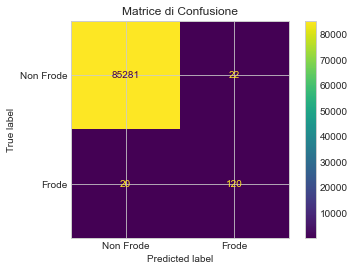

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

trainPredetto = model.predict(X_train)
testPredetto = model.predict(X_test)

cm = confusion_matrix(Y_test, testPredetto, labels=[0, 1])

cmatrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non Frode","Frode"])
cmatrix.plot()
plt.title("Matrice di Confusione")
plt.show()


## 6.2 Percentuali successo su Train-set e Test-set

In [ ]:
veriNegativi = cm[0][0]
veriPositivi = cm[1][1]
falsiPositivi = cm[0][1]
falsiNegativi = cm[1][0]

nonFrodiTotali = veriNegativi + falsiPositivi
frodiTotali = veriPositivi + falsiNegativi

percentualeDiSuccessoNonFrodi = veriNegativi / nonFrodiTotali
percentualeDiSuccessoFrodi = veriPositivi / frodiTotali

print("Train score     : {:.2f} %".format(accuracy_score(trainPredetto, Y_train) * 100))
print("Test score      : {:.2f} %".format(accuracy_score(testPredetto, Y_test) * 100))
print("Accuratezza riconoscimento frodi : {:.2f} %".format(percentualeDiSuccessoFrodi*100))
print("Accuratezza riconoscimento non frodi : {:.2f} %".format(percentualeDiSuccessoNonFrodi*100))


Train score     : 100.00 %
Test score      : 99.95 %
Accuratezza riconoscimento frodi : 85.71 %
Accuratezza riconoscimento non frodi : 99.97 %


## 6.3 Recall Score

In [ ]:
from sklearn.metrics import recall_score

print("Recall score sul test set     : {:.2f} %".format(recall_score(testPredetto, Y_test) * 100))

Recall score sul test set     : 84.51 %


## 6.X AUPRC

In [ ]:
from sklearn.metrics import average_precision_score

baseline = frodiTotali/(frodiTotali + nonFrodiTotali)
auprc = average_precision_score(Y_test, testPredetto)

print(baseline, auprc, sep="\t")

from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(model, X_test, Y_test)

_ = display.ax_.set_title("2-class Precision-Recall curve")

0.0016385192467492948	0.7245801506368595


AttributeError: type object 'PrecisionRecallDisplay' has no attribute 'from_estimator'



### 6.10.2 Balanced Accuracy
Nei casi in cui il dataset non sia bilanciato nel migliore dei modi, come nel nostro caso, ha senso anche la valutazione della balanced accuracy che calcola la media aritmetica delle accuratezze specifiche delle classi:

### 6.10.3 F1 Micro
Valutazione della F1 micro dei modelli addestrati:

### 6.10.4 F1 Macro
Valutazione della F1 macro dei modelli addestrati: